In [1]:
import os
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make plots look nice
sns.set_style("whitegrid")

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

### Download Apple stock data

In [3]:
# Parameters
TICKER = "AAPL"
START_DATE = "2010-01-01"
END_DATE = "2025-01-01"

# Create data folder
os.makedirs("../data", exist_ok=True)

# Download from Yahoo Finance
data = yf.download(TICKER, start=START_DATE, end=END_DATE)

# Save to CSV
csv_path = f"../data/{TICKER}.csv"
data.to_csv(csv_path)

print(f"Downloaded {len(data)} rows of {TICKER} data and saved to {csv_path}")
# Show first few rows
print(data.head())




/var/folders/vy/q37b89_j7wsfb9b9f0jffx980000gn/T/ipykernel_22402/1367920303.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

Downloaded 3774 rows of AAPL data and saved to ../data/AAPL.csv
Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.424606  6.439316  6.375674  6.407195  493729600
2010-01-05  6.435712  6.472036  6.401789  6.442316  601904800
2010-01-06  6.333344  6.461230  6.326740  6.435713  552160000
2010-01-07  6.321636  6.364265  6.275705  6.356760  477131200
2010-01-08  6.363665  6.364265  6.276007  6.313231  447610800


In [4]:
print("Missing values:\n", data.isna().sum())

Missing values:
 Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


### Fix Headers

In [5]:
# Flatten the multi-level columns
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

# Save clean version
data.to_csv("../data/AAPL.csv")


### Plotting

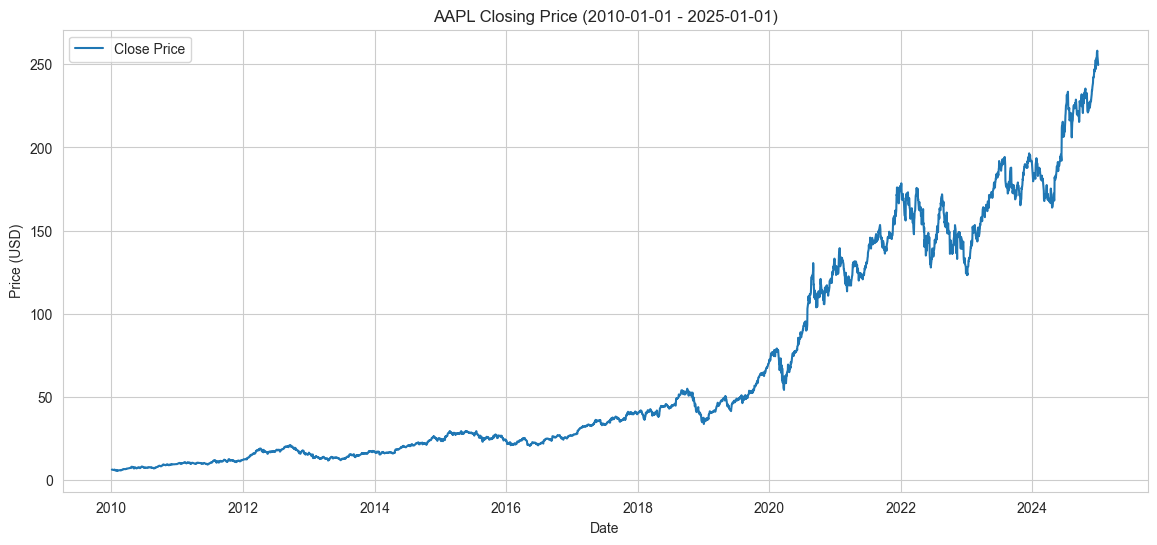

In [6]:
plt.figure(figsize=(14,6))
plt.plot(data['Close'], label='Close Price')
plt.title(f"{TICKER} Closing Price ({START_DATE} - {END_DATE})")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


## Preprocessing + Sequences

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load data
data = pd.read_csv("../data/AAPL.csv", parse_dates=["Date"], index_col="Date")

# Use only Close for now (univariate)
close_prices = data[["Close"]]

# Scale to [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Train-test split (80/20)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences
def create_sequences(dataset, lookback=60):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i, 0])  # previous `lookback` closes
        y.append(dataset[i, 0])             # next close
    return np.array(X), np.array(y)

LOOKBACK = 60
X_train, y_train = create_sequences(train_data, LOOKBACK)
X_test, y_test = create_sequences(test_data, LOOKBACK)

# Reshape for LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (2959, 60, 1) (2959,)
Test shape: (695, 60, 1) (695,)


# Baseline LSTM Model

In [8]:
# ---------------------------
# Model parameters
# ---------------------------
window_size = 60  
features = 1      

# ---------------------------
# Build LSTM model
# ---------------------------
print("Building LSTM model...")
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(window_size, features)))
model.add(Dropout(0.2))
model.add(Dense(1))  # predicting 1 value (next day's close)

model.compile(optimizer='adam', loss='mse')
model.summary()

# ---------------------------
# Train the model
# ---------------------------
print("Training the model...")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
print("Training complete.")

# ---------------------------
# Make predictions
# ---------------------------
print("Making predictions...")
y_pred = model.predict(X_test)
print("Predictions complete.")
# ---------------------------
# Evaluate
# ---------------------------
print("Evaluating model...")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100

print("Evaluation metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# ---------------------------
# Save predictions for comparison
# ---------------------------
import pandas as pd

pred_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred.flatten()
})
pred_df.to_csv("../data/baseline_lstm_predictions.csv", index=False)
print("Predictions saved to ../data/baseline_lstm_predictions.csv")

Building LSTM model...


2025-10-03 00:49:48.099910: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-10-03 00:49:48.100160: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-10-03 00:49:48.100196: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-10-03 00:49:48.100528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-03 00:49:48.100559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/arnavprasad/Documents/[02] Development/[01] Personal Projects/[21] LSTM-Stock-Price-Prediction/LSTM-Stock-Price-Prediction/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rn

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/50


2025-10-03 00:49:49.740409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.6287e-04 - val_loss: 0.0010
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.9476e-04 - val_loss: 0.0031
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.2114e-04 - val_loss: 0.0014
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.5831e-04 - val_loss: 4.3791e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.9430e-04 - val_loss: 0.0023
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.1970e-04 - val_loss: 7.7986e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.6408e-04 - val_loss: 3.8043e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.6896e-04 - val_loss: 4.4784e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.1582e-04 - val_loss: 4.0804e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.9109e-04 - val_loss: 5.1134e-04
Epoch 12/5

### Plotting Results

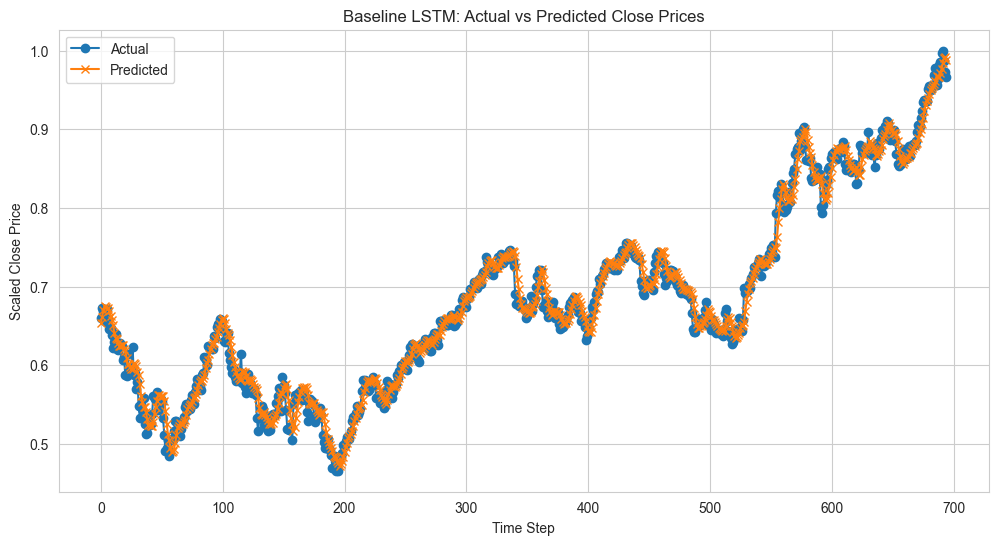

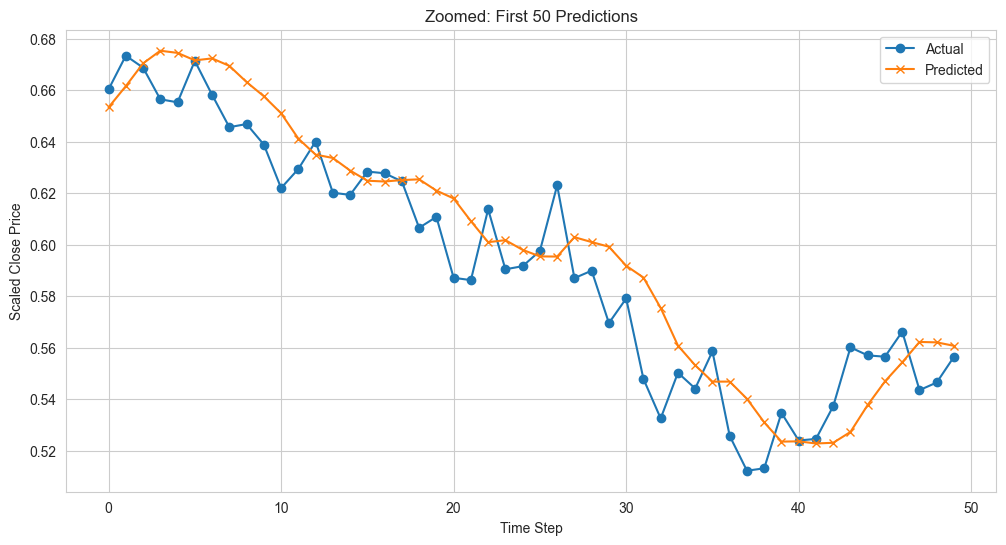

In [9]:
import matplotlib.pyplot as plt

# Assuming pred_df contains your data
plt.figure(figsize=(12,6))
plt.plot(pred_df['Actual'], label='Actual', marker='o')
plt.plot(pred_df['Predicted'], label='Predicted', marker='x')
plt.title('Baseline LSTM: Actual vs Predicted Close Prices')
plt.xlabel('Time Step')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(pred_df['Actual'][:50], label='Actual', marker='o')
plt.plot(pred_df['Predicted'][:50], label='Predicted', marker='x')
plt.title('Zoomed: First 50 Predictions')
plt.xlabel('Time Step')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()


# Stacked LSTM Layers

In [10]:
window_size = 60
features = 1

# Build stacked LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, features)))
model.add(LSTM(units=50, return_sequences=False))  # Last LSTM layer
model.add(Dense(1))  # Predict next day's close

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

print("Training complete.")

# ---------------------------
# Make predictions
# ---------------------------
print("Making predictions...")
y_pred = model.predict(X_test)
print("Predictions complete.")
# ---------------------------
# Evaluate
# ---------------------------
print("Evaluating model...")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100

print("Evaluation metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# ---------------------------
# Save predictions for comparison
# ---------------------------
import pandas as pd

pred_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred.flatten()
})
pred_df.to_csv("../data/layers_lstm_predictions.csv", index=False)
print("Predictions saved to ../data/layers_lstm_predictions.csv")


/Users/arnavprasad/Documents/[02] Development/[01] Personal Projects/[21] LSTM-Stock-Price-Prediction/LSTM-Stock-Price-Prediction/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0017 - val_loss: 8.9681e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 9.9662e-05 - val_loss: 8.0267e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.0316e-04 - val_loss: 9.2268e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 8.7364e-05 - val_loss: 8.4842e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.1340e-05 - val_loss: 6.4722e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.6831e-05 - val_loss: 0.0011
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 8.9700e-05 - val_loss: 0.0028
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 9.1136e-05 - val_loss: 5.9566e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.5403e-05 - val_loss: 9.5774e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.6928e-05 - val_loss: 4.6599e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.4772e-05 - val_loss

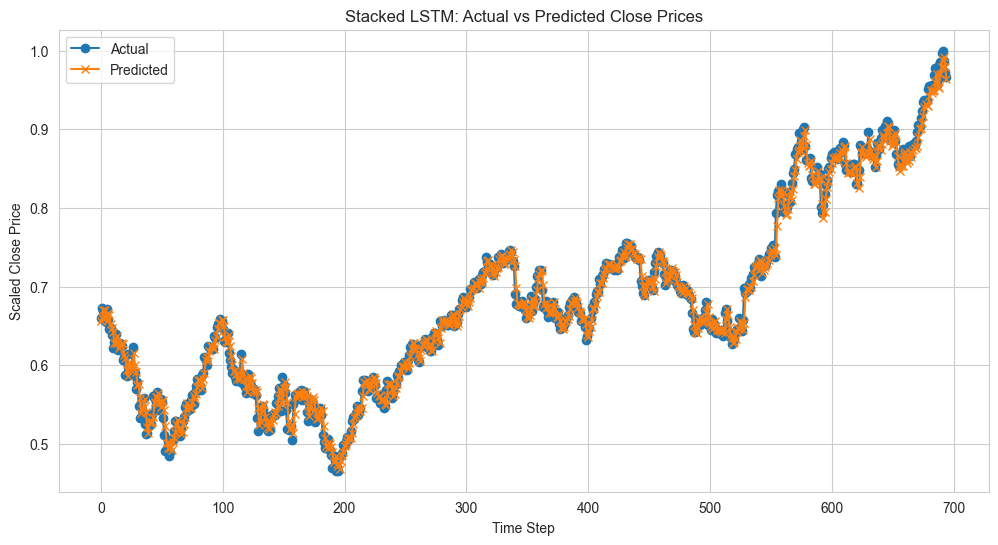

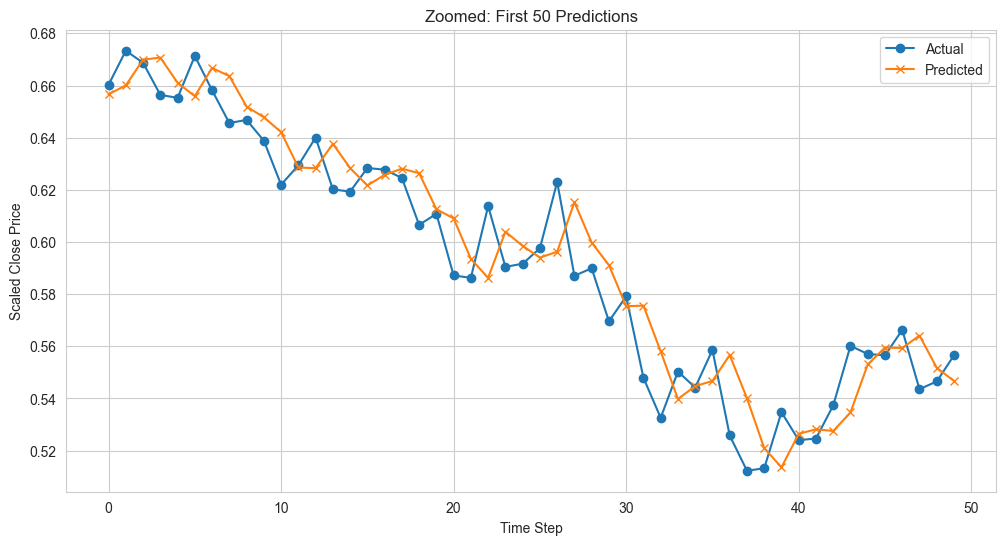

In [11]:
import matplotlib.pyplot as plt

# Assuming pred_df contains your data
plt.figure(figsize=(12,6))
plt.plot(pred_df['Actual'], label='Actual', marker='o')
plt.plot(pred_df['Predicted'], label='Predicted', marker='x')
plt.title('Stacked LSTM: Actual vs Predicted Close Prices')
plt.xlabel('Time Step')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(pred_df['Actual'][:50], label='Actual', marker='o')
plt.plot(pred_df['Predicted'][:50], label='Predicted', marker='x')
plt.title('Zoomed: First 50 Predictions')
plt.xlabel('Time Step')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()


# GRU

In [12]:
# ---------------------------
# Imports
# ---------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# ---------------------------
# Model parameters
# ---------------------------
window_size = 60  
features = 1      

# ---------------------------
# Build GRU model
# ---------------------------
print("Building GRU model...")
model = Sequential()
model.add(GRU(units=50, return_sequences=False, input_shape=(window_size, features)))
model.add(Dropout(0.2))
model.add(Dense(1))  # predicting 1 value (next day's close)

model.compile(optimizer='adam', loss='mse')
model.summary()

# ---------------------------
# Train the model
# ---------------------------
print("Training the model...")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
print("Training complete.")

# ---------------------------
# Make predictions
# ---------------------------
print("Making predictions...")
y_pred = model.predict(X_test)
print("Predictions complete.")

# ---------------------------
# Evaluate
# ---------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100

print("Evaluation metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# ---------------------------
# Save predictions for comparison
# ---------------------------
pred_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred.flatten()
})
pred_df.to_csv("../data/gru_predictions.csv", index=False)
print("Predictions saved to ../data/gru_predictions.csv")


Building GRU model...


/Users/arnavprasad/Documents/[02] Development/[01] Personal Projects/[21] LSTM-Stock-Price-Prediction/LSTM-Stock-Price-Prediction/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0066 - val_loss: 4.0835e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.3515e-04 - val_loss: 3.6471e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.0304e-04 - val_loss: 3.2545e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.1561e-04 - val_loss: 2.8803e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.0650e-04 - val_loss: 3.6345e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.1094e-04 - val_loss: 4.9630e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.8038e-04 - val_loss: 3.6375e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.8600e-04 - val_loss: 5.7246e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2.8229e-04 - val_loss: 2.6385e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.5937e-04 - val_loss: 2.9066e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

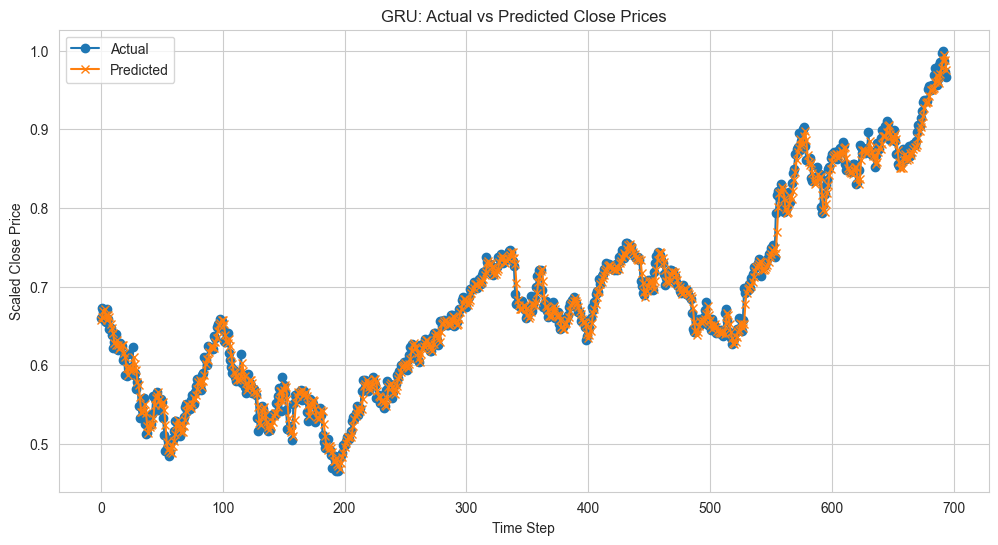

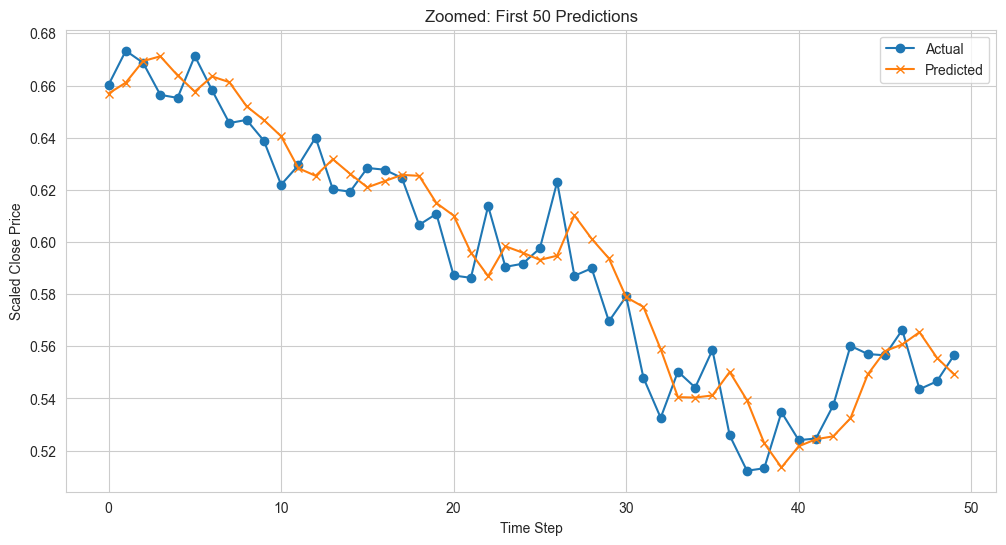

In [13]:
import matplotlib.pyplot as plt

# Assuming pred_df contains your data
plt.figure(figsize=(12,6))
plt.plot(pred_df['Actual'], label='Actual', marker='o')
plt.plot(pred_df['Predicted'], label='Predicted', marker='x')
plt.title('GRU: Actual vs Predicted Close Prices')
plt.xlabel('Time Step')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(pred_df['Actual'][:50], label='Actual', marker='o')
plt.plot(pred_df['Predicted'][:50], label='Predicted', marker='x')
plt.title('Zoomed: First 50 Predictions')
plt.xlabel('Time Step')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()


# 1D CNN

In [14]:
# ---------------------------
# Imports
# ---------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# ---------------------------
# Model parameters
# ---------------------------
window_size = 60  
features = 1      

# ---------------------------
# Build 1D CNN model
# ---------------------------
print("Building 1D CNN model...")
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1))  # predicting next day's close

model.compile(optimizer='adam', loss='mse')
model.summary()

# ---------------------------
# Train the model
# ---------------------------
print("Training the model...")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
print("Training complete.")

# ---------------------------
# Make predictions
# ---------------------------
print("Making predictions...")
y_pred = model.predict(X_test)
print("Predictions complete.")

# ---------------------------
# Evaluate
# ---------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100

print("Evaluation metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# ---------------------------
# Save predictions for comparison
# ---------------------------
pred_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred.flatten()
})
pred_df.to_csv("../data/cnn1d_predictions.csv", index=False)
print("Predictions saved to ../data/cnn1d_predictions.csv")


Building 1D CNN model...


/Users/arnavprasad/Documents/[02] Development/[01] Personal Projects/[21] LSTM-Stock-Price-Prediction/LSTM-Stock-Price-Prediction/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 27, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           417 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,849 (26.75 KB)

 Trainable params: 6,849 (26.75 KB)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.0157e-04 - val_loss: 0.0025
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.3725e-04 - val_loss: 0.0023
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.8844e-04 - val_loss: 0.0021
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.5687e-04 - val_loss: 0.0029
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.8577e-04 - val_loss: 0.0024
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.5364e-04 - val_loss: 0.0019
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.9376e-04 - val_loss: 0.0037
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.4184e-04 - val_loss: 0.0035
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.8500e-04 - val_loss: 0.0018
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.2522e-04 - val_loss: 0.0018
E

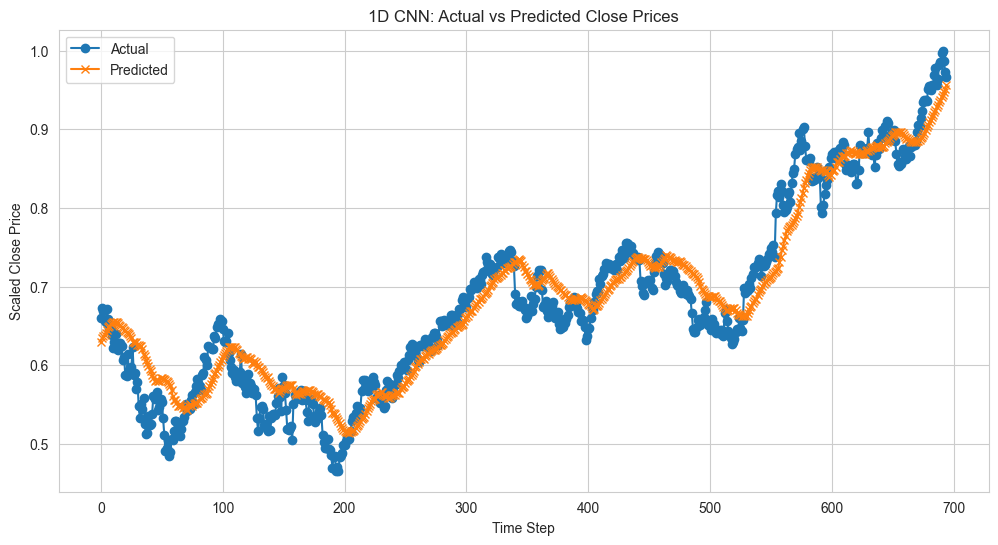

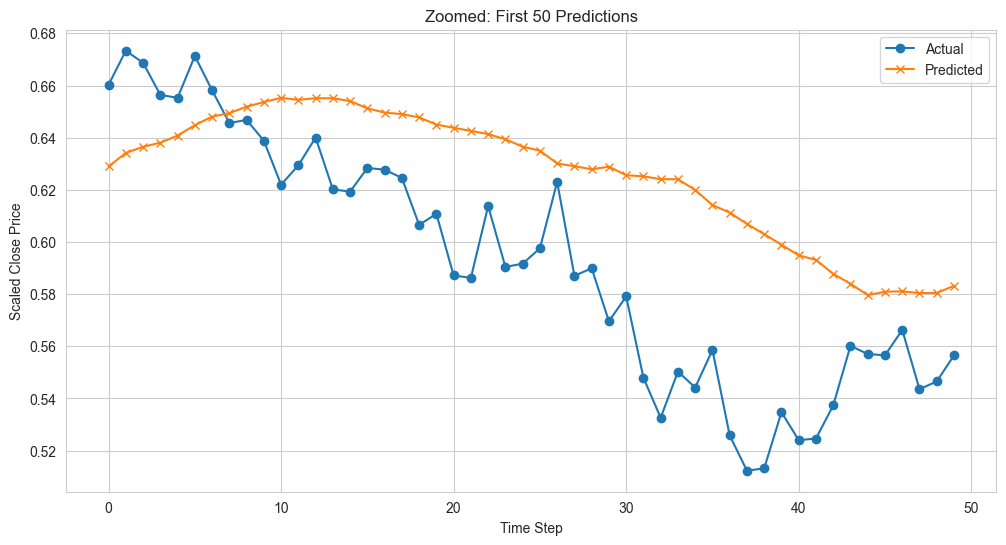

In [ ]:
import matplotlib.pyplot as plt

# Assuming pred_df contains your data
plt.figure(figsize=(12,6))
plt.plot(pred_df['Actual'], label='Actual', marker='o')
plt.plot(pred_df['Predicted'], label='Predicted', marker='x')
plt.title('1D CNN: Actual vs Predicted Close Prices')
plt.xlabel('Time Step')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(pred_df['Actual'][:50], label='Actual', marker='o')
plt.plot(pred_df['Predicted'][:50], label='Predicted', marker='x')
plt.title('Zoomed: First 50 Predictions')
plt.xlabel('Time Step')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.show()
